In [1]:
%matplotlib inline
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from e11.tools import df_from_dict_of_tuples
from e11.fit import Gaussian

## Generate data

In [2]:
def gauss(x, x0, amp, sigma, offset):
    """ 1D gaussian """
    return amp * np.exp(-0.5 * (((x - x0) / sigma)**2.0)) + offset

# generate 1d data
nx = 500
xvals = np.arange(nx)
arr = []
std = 1.2
labels = [-1.4, -0.5, 0.4]
data_pars = {}
for lbl, x0, amp, sigma in zip(labels,
                               [100, 200, 300],
                               [18, 12, 6],
                               [40, 50, 60]):
    p0 = [x0, amp, sigma, 2]
    data_pars[lbl] = dict(zip(Gaussian(None, None).variables, p0))
    yvals = gauss(xvals, *p0) + std * np.random.randn(nx)
    arr.append(yvals)
arr = np.array(arr)
data_pars = pd.DataFrame.from_dict(data_pars, orient="index")

In [3]:
data_pars

,x0,amp,sigma,offset
-1.4,100,18,40,2
-0.5,200,12,50,2
0.4,300,6,60,2


## Fit data

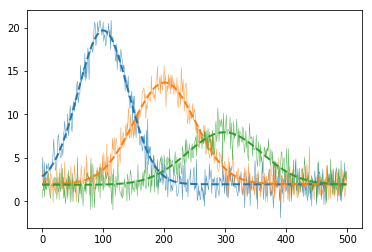

In [4]:
fig, ax = plt.subplots()

fit_pars = {}
reduced_chi_sq = {}
for lbl, yvals in zip(labels, arr):
    # data
    p = ax.plot(xvals, yvals, lw=0.5, alpha=0.8, zorder=5)
    color = p[0].get_color()
    # fit
    g = Gaussian(xvals, yvals)
    popt, perr = g.fit()
    ax.plot(g.xdata, g.best_fit, color=color, ls="--", lw=2, zorder=10)
    # reduced chi_sq
    reduced_chi_sq[lbl] = np.sum(g.residuals**2 / (std**2)) / (nx - len(g.variables))
    # record
    fit_pars[lbl] = g.asdict()

fit_pars = df_from_dict_of_tuples(fit_pars)
plt.show()

In [5]:
pd.Series(reduced_chi_sq)

-1.4    0.961317
-0.5    0.951238
 0.4    0.965906
dtype: float64

In [6]:
fit_pars

x0                  amp                sigma            \
           value     error      value     error      value     error   
-1.4  100.127839  0.452476  17.722299  0.177190  41.005681  0.500894   
-0.5  200.753419  0.760077  11.683866  0.160368  51.024988  0.897397   
 0.4  298.755968  1.618036   6.049237  0.152557  61.038477  2.042225   

        offset            
         value     error  
-1.4  1.953560  0.068341  
-0.5  1.988641  0.077351  
 0.4  1.894359  0.088338

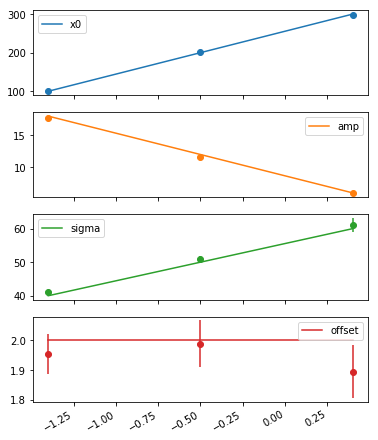

In [7]:
axes = data_pars.plot(subplots=True, figsize=(6, 8))

for i, var in enumerate(g.variables):
    yvals = fit_pars[(var, "value")]
    yerr = fit_pars[(var, "error")]
    axes[i].errorbar(yvals.index, yvals.values, yerr=yerr.values, c="C%d"%i, ls="", marker="o")
plt.show()